# Plots for spectrum prediction with ASAP compounds

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Load OpenEye license, required by the asapdiscovery package
!export OE_LICENSE=$HOME/Documents/.openeye/oe_license.txt

In [2]:
# Import all the required modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scripts.plot_results import (
    plot_bar_scores_in_df, 
    plot_score_correlation, 
    scatter_scores, 
    get_roc_curve, 
    get_conf_mat,
    bootstrap_auc
)

In [3]:
df_scores = pd.read_csv("data/asap_genetics_scores.csv") 
print(df_scores.head())

          prot-ID  premin-score-POSIT  docking-score-POSIT  \
0     NP_835346_1           -6.353159           -12.529802   
1     NP_835346_1           -6.658897           -13.583808   
2     NP_835346_1           -3.106442           -10.396547   
3  YP_008439216_1           -5.196997            -8.831543   
4  YP_008439216_1           -6.457805            -8.563966   

   computed-SchNet-pIC50  computed-E3NN-pIC50  computed-GAT-pIC50  Lig-RMSD  \
0               4.049343          3753.523438            8.393321  0.520532   
1               3.108124          4064.304688            7.949432  0.513178   
2               3.642510          3653.554688            6.384541  1.107971   
3               1.513343          3942.007812            8.393321  0.864898   
4               3.059722          4104.984375            7.949432  0.881038   

   Vina-score-premin  Vina-score-min  gnina-RMSD  ...  CNN_dock_affinity  \
0             -8.963          -9.235      0.2278  ...             7.5080   


In [4]:
df_scores["Activity"] = df_scores["signal"].apply(lambda x: "active" if x > 50 else "partial" if x > 30 else "inactive")
sars_gen_A1 = df_scores[df_scores["lig-ID"] == "ASAP-0020960"]
sars_gen_A1 = sars_gen_A1.reset_index()
sars_gen_B1 = df_scores[df_scores["lig-ID"] == "ASAP-0017445"]
sars_gen_B1 = sars_gen_B1.reset_index()
sars_gen_C1 = df_scores[df_scores["lig-ID"] == "ASAP-0016506"]
sars_gen_C1 = sars_gen_C1.reset_index()

In [5]:
def min_max_scale(df0, feats):
    from sklearn.preprocessing  import MinMaxScaler
    scaler = MinMaxScaler()
    df = df0.copy()
    df[feats] = scaler.fit_transform(df[feats])

    return df[feats]

def get_scores(df, selection, selection_value):

    df_filtered = df[df[selection] == selection_value].reset_index()
    df_filtered['Vina-score-premin'] = -df_filtered['Vina-score-premin']  
    df_filtered['docking-score-POSIT'] = -df_filtered['docking-score-POSIT']
    df_filtered['Lig-RMSD'] = df_filtered['Lig-RMSD'].replace(-1, 10)

    score1 = min_max_scale(df_filtered, ['docking-score-POSIT']).values
    score2 = min_max_scale(df_filtered, ['Vina-score-premin']).values
    score3 = min_max_scale(df_filtered, ['signal']).values
    score4 = min_max_scale(df_filtered, ['Bsite-seq-identity']).values
    score5 = min_max_scale(df_filtered, ['CNN_dock_affinity']).values
    score6 = min_max_scale(df_filtered, ['ByInteractionTypeAndResidueType']).values
    score7 = 1/(1+df_filtered['Lig-RMSD'])
    score8 = min_max_scale(df_filtered, ['computed-SchNet-pIC50']).values
    d_vals = {
        'Pocket-Seq\nSimilarity': tuple(score4.reshape(-1)),
        'PLIF': tuple(score6.reshape(-1)),
        'Gnina CNN': tuple(score5.reshape(-1)),
        'AutoDock Vina':  tuple(score2.reshape(-1)),
        'ChemGauss4': tuple(score1.reshape(-1)),
        #'RMSD': tuple(score7),
        #'SchNet': tuple(score8.reshape(-1)),
        'Signal Inhibition': tuple(score3.reshape(-1)),  
    }
    alpha_dict = {
        'Pocket-Seq\nSimilarity': 1,
        'PLIF': 1,
        'Gnina CNN': 1,
        'AutoDock Vina': 1,
        'ChemGauss4': 1,
        #'RMSD': 1,
        #SchNet': 1, 
        'Signal Inhibition': 1,    
    }

    df_scores = pd.DataFrame(d_vals)
    df_scores['blast-descriptor'] = df_filtered['blast-descriptor']
    df_scores["Activity"] = df_filtered["Activity"]

    return df_scores, d_vals, alpha_dict

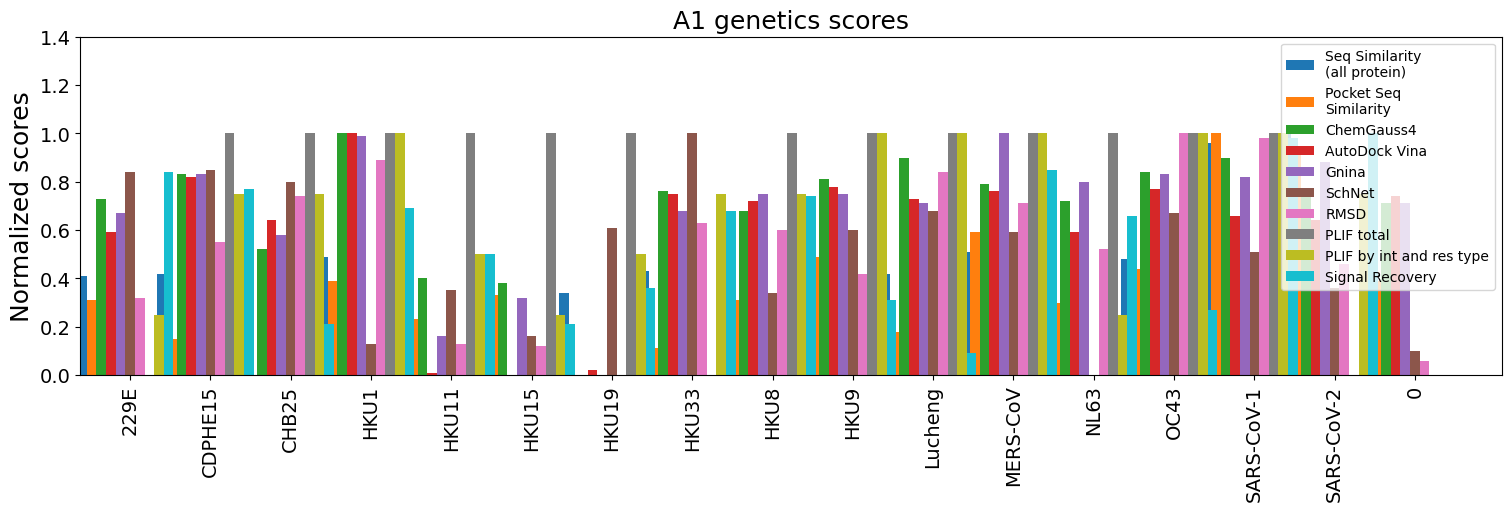

In [6]:
col_labels = ['blast-scores', 
              'Bsite-seq-identity',
              'docking-score-POSIT', 
              'Vina-score-premin', 
              'CNN_dock_affinity',
              'computed-SchNet-pIC50',
              'RMSD',
              'ByTotalInteractions',
              'ByInteractionTypeAndResidueType',
              'signal', 
              ]
score_labels = ['Seq Similarity\n(all protein)',
                'Pocket Seq\nSimilarity',
                'ChemGauss4', 
                'AutoDock Vina', 
                'Gnina', 
                'SchNet', 
                'RMSD',
                'PLIF total',
                'PLIF by int and res type',
                'Signal Recovery']
sign_list = [1,1,-1,-1,1,1,1,1,1,1]
sars_gen_A1['Lig-RMSD'] = sars_gen_A1['Lig-RMSD'].replace(-1, 10)
sars_gen_A1['RMSD'] = 1/(1+sars_gen_A1['Lig-RMSD'])

fig = plot_bar_scores_in_df(sars_gen_A1, target_labels=sars_gen_A1['blast-descriptor'], 
                            label_cols=col_labels, sign_list=sign_list, 
                            score_labels=score_labels,
                            title='A1 genetics scores', yrange=[0, 1.4], 
                            ylabel='Normalized scores', figsize=(15,5.), label_bars=False, bar_width=0.12)

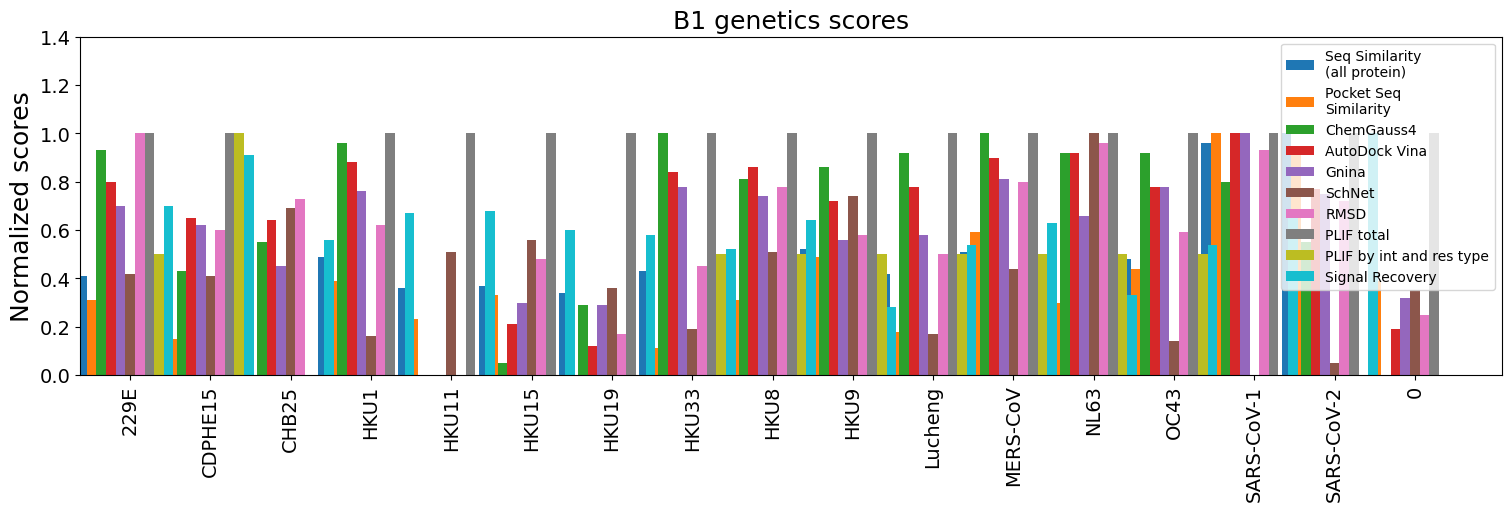

In [7]:
sars_gen_B1['Lig-RMSD'] = sars_gen_B1['Lig-RMSD'].replace(-1, 10)
sars_gen_B1['RMSD'] = 1/(1+sars_gen_B1['Lig-RMSD'])
#df_gen_B1['Vina-score-premin'] = -df_gen_B1['Vina-score-premin']  
#df_gen_B1['docking-score-POSIT'] = -df_gen_B1['docking-score-POSIT']
fig = plot_bar_scores_in_df(sars_gen_B1, target_labels=sars_gen_B1['blast-descriptor'], 
                            label_cols=col_labels, sign_list=sign_list, 
                            score_labels=score_labels,
                            title='B1 genetics scores', yrange=[0, 1.4], 
                            ylabel='Normalized scores', figsize=(15,5.), label_bars=False, bar_width=0.12)

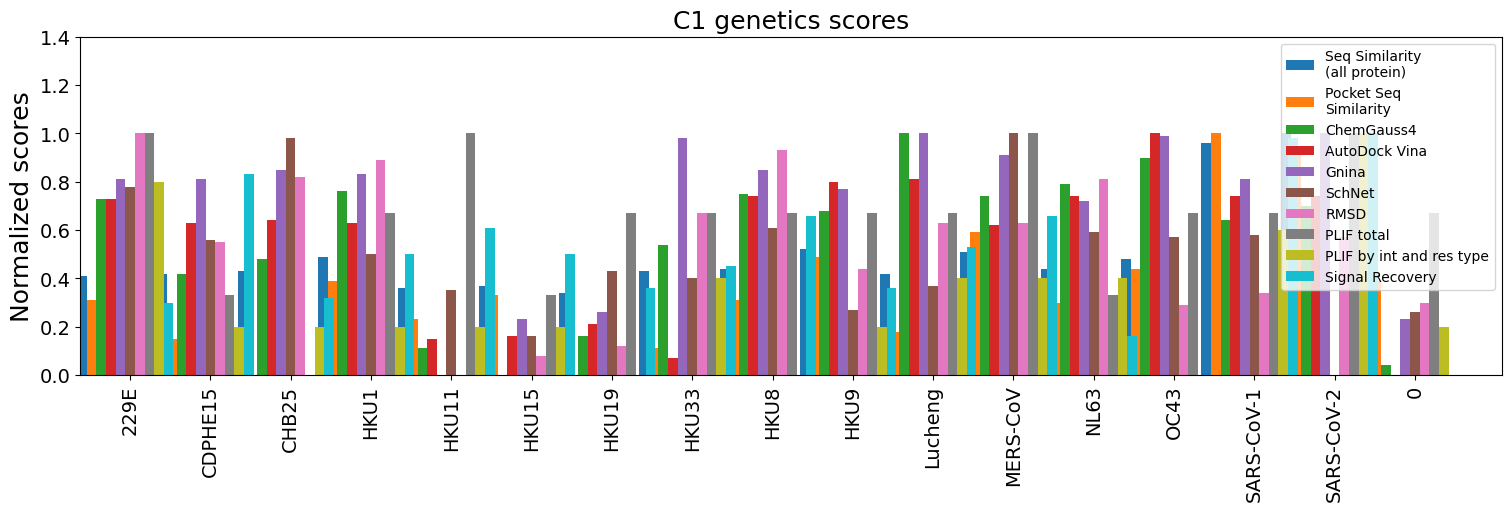

In [8]:
sars_gen_C1['Lig-RMSD'] = sars_gen_C1['Lig-RMSD'].replace(-1, 10)
sars_gen_C1['RMSD'] = 1/(1+sars_gen_C1['Lig-RMSD'])
#df_gen_C1['Vina-score-premin'] = -df_gen_C1['Vina-score-premin']  
#df_gen_C1['docking-score-POSIT'] = -df_gen_C1['docking-score-POSIT']
fig = plot_bar_scores_in_df(sars_gen_C1, target_labels=sars_gen_C1['blast-descriptor'], 
                            label_cols=col_labels, sign_list=sign_list, 
                            score_labels=score_labels,
                            title='C1 genetics scores', yrange=[0, 1.4], 
                            ylabel='Normalized scores', figsize=(15,5.), label_bars=False, bar_width=0.12)

It is important to observe the correlation between different scores, especially, with respect to the experimental *Signal Inhibition*. We compare the correlation of each score with the experimental signal on a bar plot.

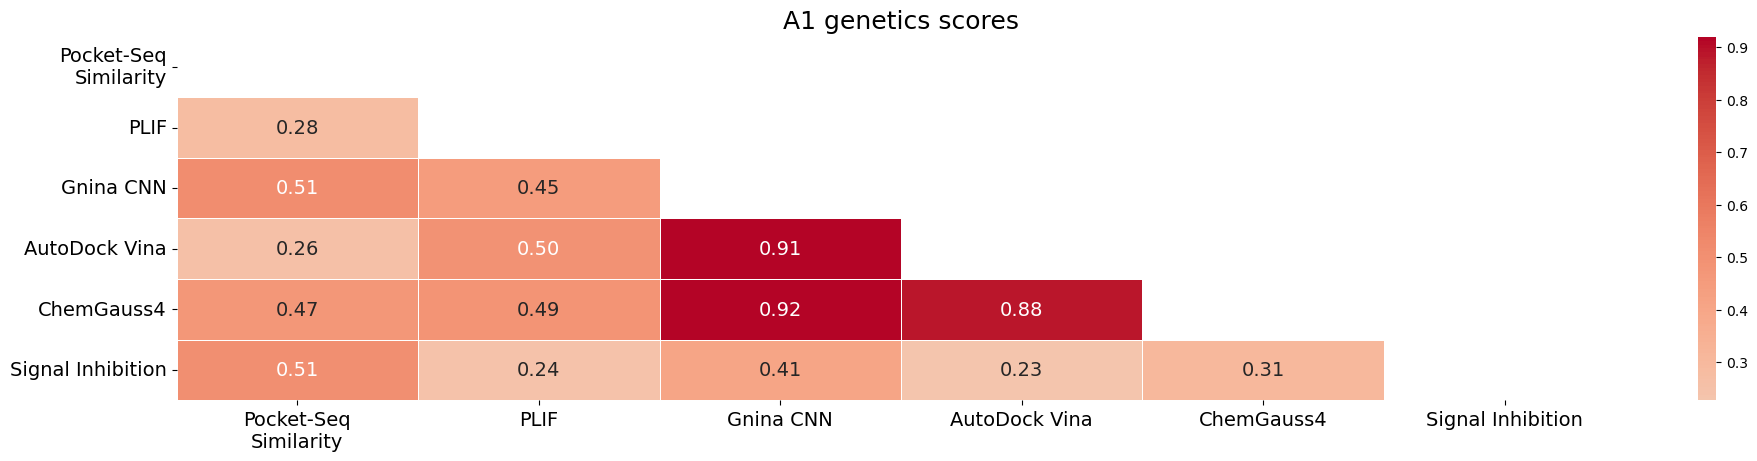

In [9]:
df_scoresA, d_vals, alpha_dict = get_scores(df_scores, "lig-ID", "ASAP-0020960")

fig = plot_score_correlation(df_scoresA, 'blast-descriptor', 'signal', 'A1 genetics scores', [-0.05, 1.05], 'Signal Inhibition', 'Normalized scores',
                  figsize=(17.5,4.5), type='heatmap')

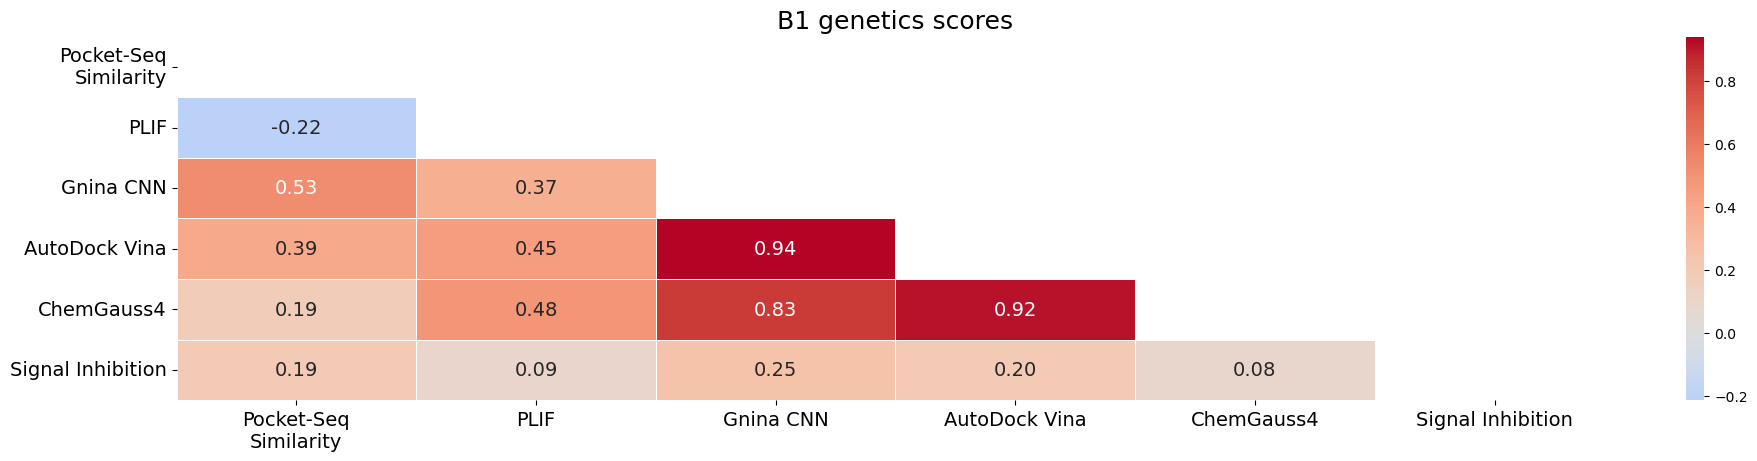

In [10]:
df_scoresB, d_vals, alpha_dict = get_scores(df_scores, "lig-ID", "ASAP-0017445")
fig = plot_score_correlation(df_scoresB, 'blast-descriptor', 'signal', 'B1 genetics scores', [-0.05, 1.05], 'Signal Inhibition', 'Normalized scores',
                  figsize=(17.5,4.5), type='heatmap')

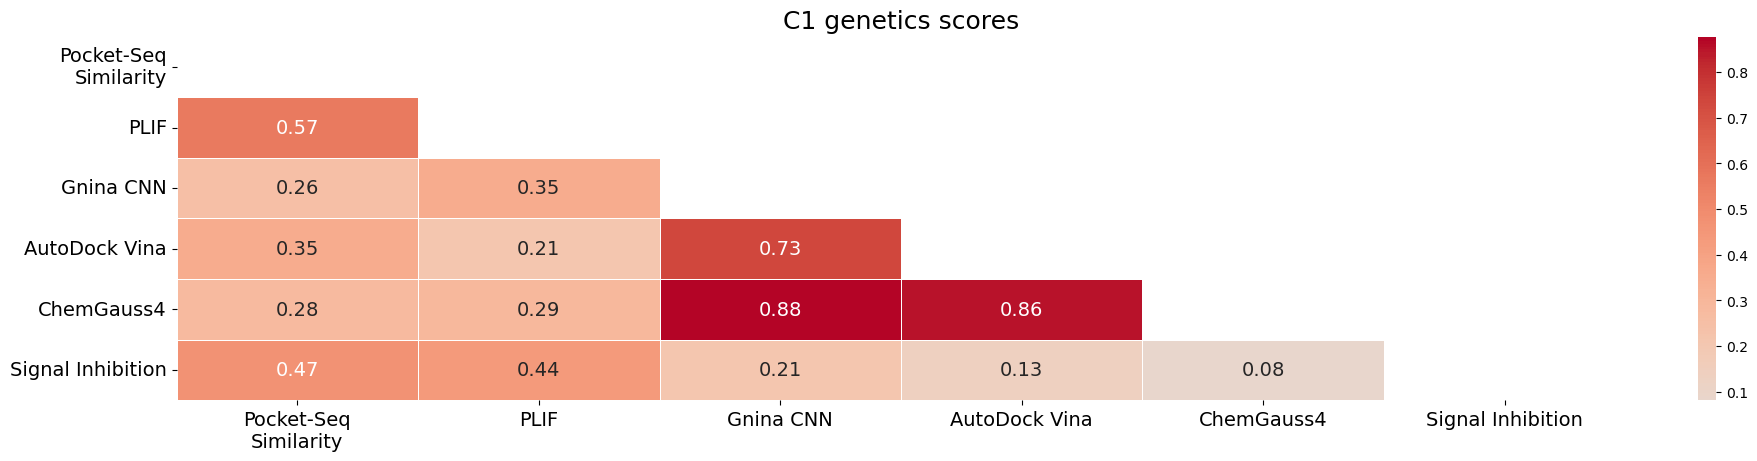

In [11]:
df_scoresC, d_vals, alpha_dict = get_scores(df_scores, "lig-ID", "ASAP-0016506")
fig = plot_score_correlation(df_scoresC, 'blast-descriptor', 'signal', 'C1 genetics scores', [-0.05, 1.05], 'Signal Inhibition', 'Normalized scores',
                  figsize=(17.5,4.5), type='heatmap')

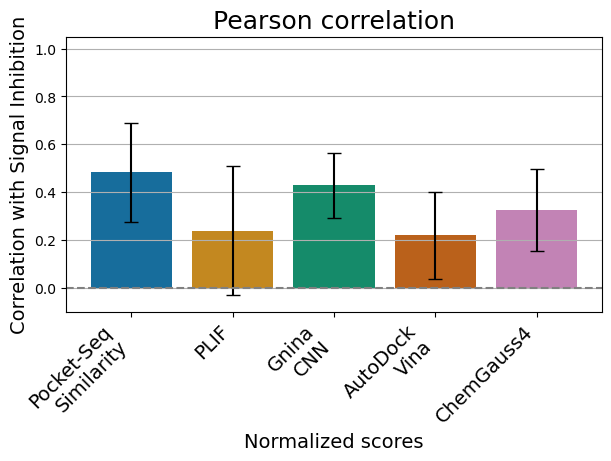

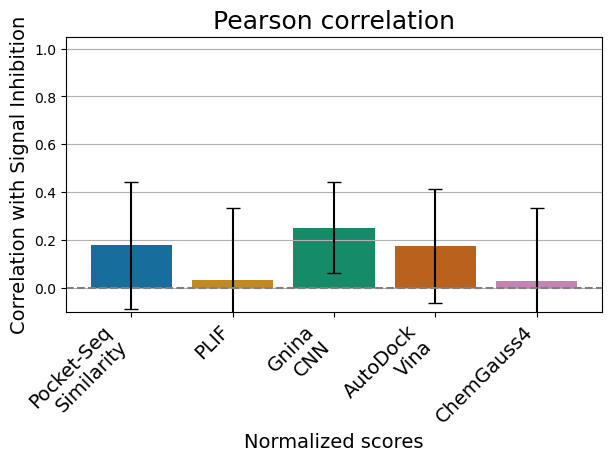

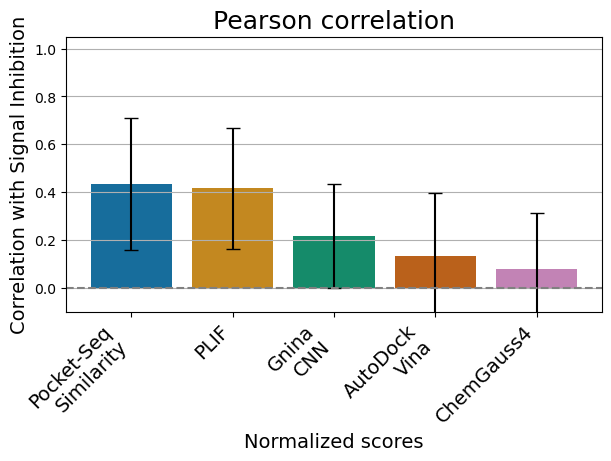

In [12]:
dfs = {"ASAP-0020960": df_scoresA, "ASAP-0017445": df_scoresB, "ASAP-0016506": df_scoresC}
for ligand, df in dfs.items():
    fig, ax = plot_score_correlation(df, 'blast-descriptor', 'Signal Inhibition', 'Pearson correlation', yrange=[-0.1, 1.05], ylabel='Signal Inhibition', xlabel='Normalized scores',
                    figsize=(6,4.5), type='bars', error_type='var', color_palette='colorblind')

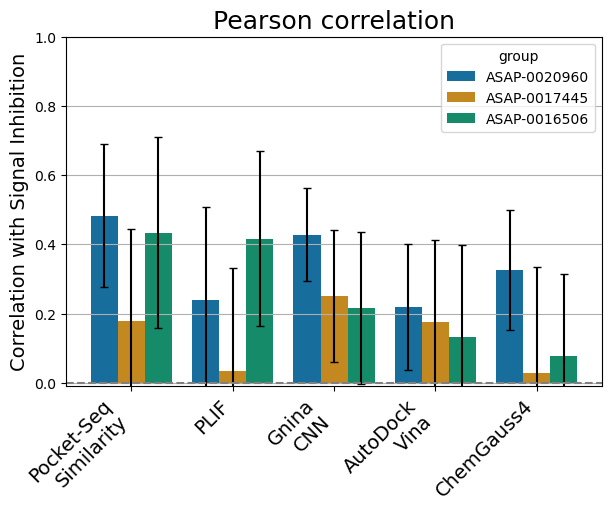

In [13]:
dfs = {"ASAP-0020960": df_scoresA, "ASAP-0017445": df_scoresB, "ASAP-0016506": df_scoresC}
fig, ax = plot_score_correlation(dfs, 'blast-descriptor', 'Signal Inhibition', 'Pearson correlation', yrange=[-0.01, 1.0], ylabel='Signal Inhibition', xlabel='',
                figsize=(6,5), type='bars', error_type='var', color_palette='colorblind', grouped=True)
fig.savefig("/Users/castelm3/Documents/Github/asapdiscovery_orig/local/SARS_genetics/score_correlations_asap.pdf", bbox_inches='tight', pad_inches=0.5)


## Confusion matrices for each case

### A1

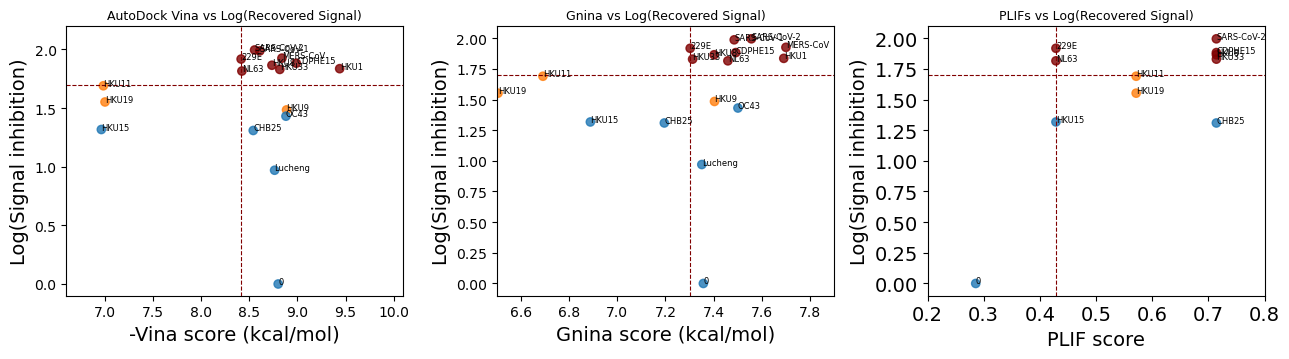

In [14]:
signal = np.log10(sars_gen_A1['signal'])
signal[signal == -np.inf] = 0
true_actives = sars_gen_A1[sars_gen_A1['Activity'] == 'active']

fig, axs = plt.subplots(1, 3, figsize=(13,3.7))

ax1 = scatter_scores(axs[0], -sars_gen_A1['Vina-score-premin'], signal,
                    '-Vina score (kcal/mol)', 'Log(Signal inhibition)',title='AutoDock Vina vs Log(Recovered Signal)',
                    ylim=(-0.1, 2.2), xlim=(6.6, 10.1), point_labels=sars_gen_A1["blast-descriptor"],  hue=sars_gen_A1['Activity'], linear=False)
ax1.axline((0, np.log10(50)), slope=0, color='maroon', linestyle='--', linewidth=0.8)
ax1.axvline(min(-true_actives['Vina-score-premin']), color='maroon', linestyle='--', linewidth=0.8)

ax2 = scatter_scores(axs[1], sars_gen_A1['CNN_dock_affinity'], signal,
                    'Gnina score (kcal/mol)', 'Log(Signal inhibition)', title='Gnina vs Log(Recovered Signal)',
                    ylim=(-0.1, 2.1), xlim=(6.5, 7.9), point_labels=sars_gen_A1["blast-descriptor"], hue=sars_gen_A1['Activity'], linear=False)
ax2.axline((0, np.log10(50)), slope=0, color='maroon', linestyle='--', linewidth=0.8)
ax2.axvline(min(true_actives['CNN_dock_affinity']), color='maroon', linestyle='--', linewidth=0.8)

ax3 = scatter_scores(axs[2], sars_gen_A1['ByInteractionTypeAndResidueType'], signal,
                    'PLIF score', 'Log(Signal inhibition)', title='PLIFs vs Log(Recovered Signal)',
                    ylim=(-0.1, 2.1), xlim=(0.2, 0.8), point_labels=sars_gen_A1["blast-descriptor"], hue=sars_gen_A1['Activity'], linear=False)
ax3.axline((0, np.log10(50)), slope=0, color='maroon', linestyle='--', linewidth=0.8)
ax3.axvline(min(true_actives['ByInteractionTypeAndResidueType']), color='maroon', linestyle='--', linewidth=0.8)
plt.tight_layout()

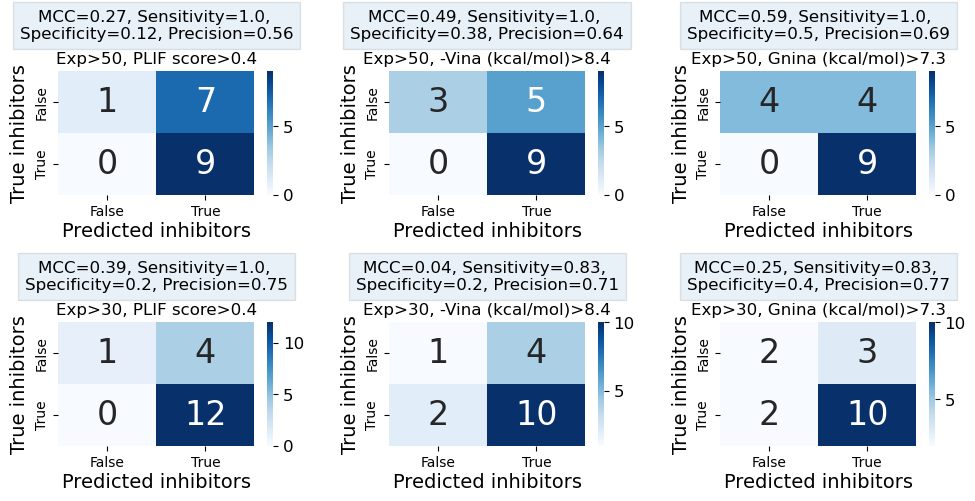

In [15]:
true_actives = sars_gen_A1[sars_gen_A1['Activity'] == 'active']
true_actives_ext = sars_gen_A1[sars_gen_A1['Activity'].isin(['active','partial'])]

fig, axs = plt.subplots(2, 3, figsize=(10, 5.2))
ax2 = get_conf_mat(axs[0, 0], sars_gen_A1['ByInteractionTypeAndResidueType'], sars_gen_A1['signal'], min(true_actives['ByInteractionTypeAndResidueType']), 50, 'PLIF score')
ax1 = get_conf_mat(axs[1, 0], sars_gen_A1['ByInteractionTypeAndResidueType'], sars_gen_A1['signal'], min(true_actives['ByInteractionTypeAndResidueType']), 30, 'PLIF score')

ax2 = get_conf_mat(axs[0, 1], -sars_gen_A1['Vina-score-premin'], sars_gen_A1['signal'], min(-true_actives['Vina-score-premin']), 50, '-Vina (kcal/mol)')
ax1 = get_conf_mat(axs[1, 1], -sars_gen_A1['Vina-score-premin'], sars_gen_A1['signal'], min(-true_actives['Vina-score-premin']), 30, '-Vina (kcal/mol)')

ax2 = get_conf_mat(axs[0, 2], sars_gen_A1['CNN_dock_affinity'], sars_gen_A1['signal'], min(true_actives['CNN_dock_affinity']), 50, 'Gnina (kcal/mol)')
ax1 = get_conf_mat(axs[1, 2], sars_gen_A1['CNN_dock_affinity'], sars_gen_A1['signal'], min(true_actives['CNN_dock_affinity']), 30, 'Gnina (kcal/mol)')

fig.subplots_adjust(hspace=1)
fig.tight_layout()

### B1

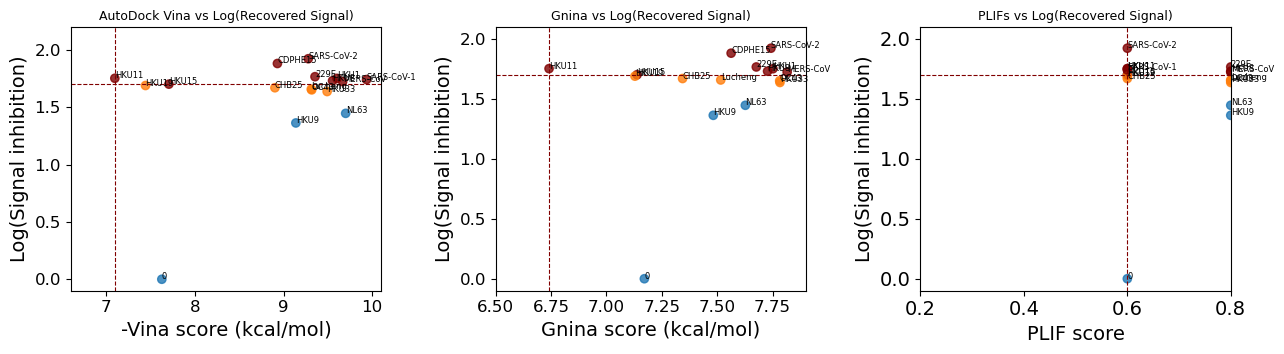

In [16]:
signal = np.log10(sars_gen_B1['signal'])
signal[signal == -np.inf] = 0
true_actives = sars_gen_B1[sars_gen_B1['Activity'] == 'active']

fig, axs = plt.subplots(1, 3, figsize=(13,3.7))

ax1 = scatter_scores(axs[0], -sars_gen_B1['Vina-score-premin'], signal,
                    '-Vina score (kcal/mol)', 'Log(Signal inhibition)',title='AutoDock Vina vs Log(Recovered Signal)',
                    ylim=(-0.1, 2.2), xlim=(6.6, 10.1), point_labels=sars_gen_B1["blast-descriptor"],  hue=sars_gen_B1['Activity'], linear=False)
ax1.axline((0, np.log10(50)), slope=0, color='maroon', linestyle='--', linewidth=0.8)
ax1.axvline(min(-true_actives['Vina-score-premin']), color='maroon', linestyle='--', linewidth=0.8)

ax2 = scatter_scores(axs[1], sars_gen_B1['CNN_dock_affinity'], signal,
                    'Gnina score (kcal/mol)', 'Log(Signal inhibition)', title='Gnina vs Log(Recovered Signal)',
                    ylim=(-0.1, 2.1), xlim=(6.5, 7.9), point_labels=sars_gen_B1["blast-descriptor"], hue=sars_gen_B1['Activity'], linear=False)
ax2.axline((0, np.log10(50)), slope=0, color='maroon', linestyle='--', linewidth=0.8)
ax2.axvline(min(true_actives['CNN_dock_affinity']), color='maroon', linestyle='--', linewidth=0.8)

ax3 = scatter_scores(axs[2], sars_gen_B1['ByInteractionTypeAndResidueType'], signal,
                    'PLIF score', 'Log(Signal inhibition)', title='PLIFs vs Log(Recovered Signal)',
                    ylim=(-0.1, 2.1), xlim=(0.2, 0.8), point_labels=sars_gen_B1["blast-descriptor"], hue=sars_gen_B1['Activity'], linear=False)
ax3.axline((0, np.log10(50)), slope=0, color='maroon', linestyle='--', linewidth=0.8)
ax3.axvline(min(true_actives['ByInteractionTypeAndResidueType']), color='maroon', linestyle='--', linewidth=0.8)
plt.tight_layout()

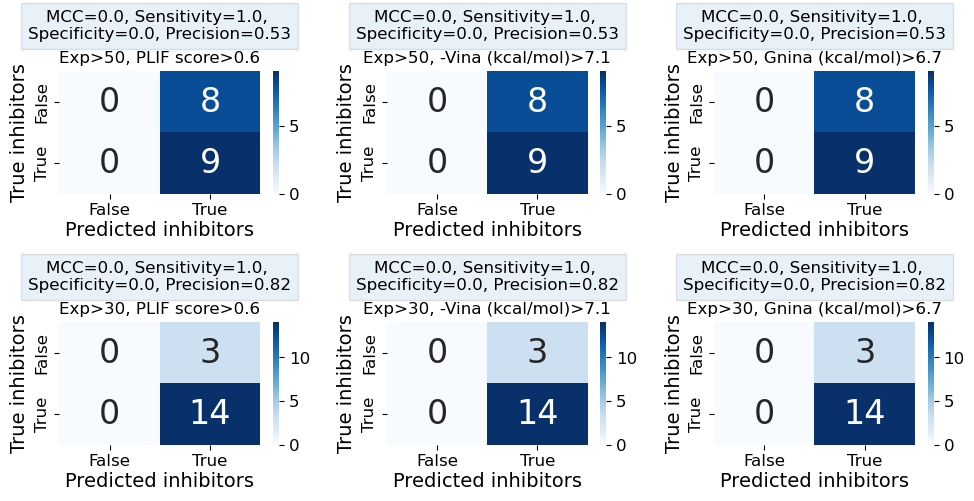

In [17]:
true_actives = sars_gen_B1[sars_gen_B1['Activity'] == 'active']
true_actives_ext = sars_gen_B1[sars_gen_B1['Activity'].isin(['active','partial'])]

fig, axs = plt.subplots(2, 3, figsize=(10, 5.2))
ax2 = get_conf_mat(axs[0, 0], sars_gen_B1['ByInteractionTypeAndResidueType'], sars_gen_B1['signal'], min(true_actives['ByInteractionTypeAndResidueType']), 50, 'PLIF score')
ax1 = get_conf_mat(axs[1, 0], sars_gen_B1['ByInteractionTypeAndResidueType'], sars_gen_B1['signal'], min(true_actives['ByInteractionTypeAndResidueType']), 30, 'PLIF score')

ax2 = get_conf_mat(axs[0, 1], -sars_gen_B1['Vina-score-premin'], sars_gen_B1['signal'], min(-true_actives['Vina-score-premin']), 50, '-Vina (kcal/mol)')
ax1 = get_conf_mat(axs[1, 1], -sars_gen_B1['Vina-score-premin'], sars_gen_B1['signal'], min(-true_actives['Vina-score-premin']), 30, '-Vina (kcal/mol)')

ax2 = get_conf_mat(axs[0, 2], sars_gen_B1['CNN_dock_affinity'], sars_gen_B1['signal'], min(true_actives['CNN_dock_affinity']), 50, 'Gnina (kcal/mol)')
ax1 = get_conf_mat(axs[1, 2], sars_gen_B1['CNN_dock_affinity'], sars_gen_B1['signal'], min(true_actives['CNN_dock_affinity']), 30, 'Gnina (kcal/mol)')

fig.subplots_adjust(hspace=1)
fig.tight_layout()

### C1

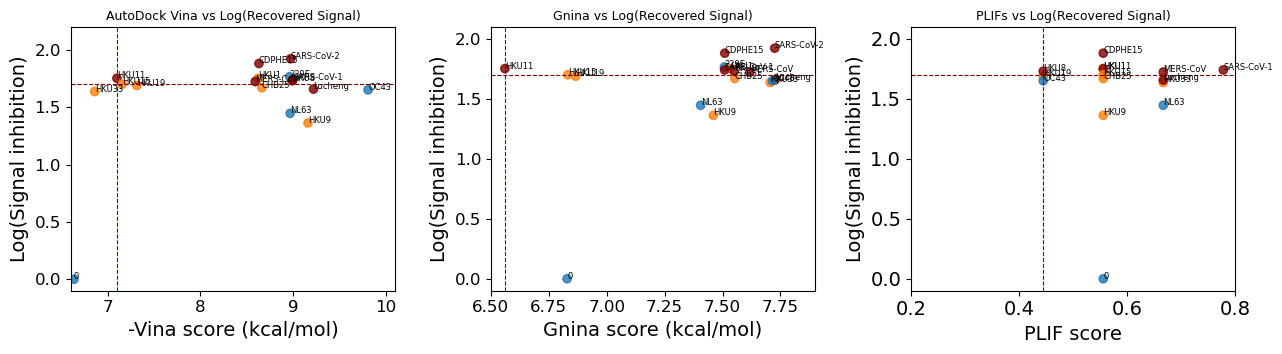

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(13,3.7))
signal[signal == -np.inf] = 0
true_actives = sars_gen_C1[sars_gen_C1['Activity'] == 'active']

ax1 = scatter_scores(axs[0], -sars_gen_C1['Vina-score-premin'], signal,
                    '-Vina score (kcal/mol)', 'Log(Signal inhibition)',title='AutoDock Vina vs Log(Recovered Signal)',
                    ylim=(-0.1, 2.2), xlim=(6.6, 10.1), point_labels=sars_gen_C1["blast-descriptor"],  hue=sars_gen_C1['Activity'], linear=False)
ax1.axline((0, np.log10(50)), slope=0, color='maroon', linestyle='--', linewidth=0.8)
ax1.axvline(min(-true_actives['Vina-score-premin']), color='maroon', linestyle='--', linewidth=0.8)

ax2 = scatter_scores(axs[1], sars_gen_C1['CNN_dock_affinity'], signal,
                    'Gnina score (kcal/mol)', 'Log(Signal inhibition)', title='Gnina vs Log(Recovered Signal)',
                    ylim=(-0.1, 2.1), xlim=(6.5, 7.9), point_labels=sars_gen_C1["blast-descriptor"], hue=sars_gen_C1['Activity'], linear=False)
ax2.axline((0, np.log10(50)), slope=0, color='maroon', linestyle='--', linewidth=0.8)
ax2.axvline(min(true_actives['CNN_dock_affinity']), color='maroon', linestyle='--', linewidth=0.8)

ax3 = scatter_scores(axs[2], sars_gen_C1['ByInteractionTypeAndResidueType'], signal,
                    'PLIF score', 'Log(Signal inhibition)', title='PLIFs vs Log(Recovered Signal)',
                    ylim=(-0.1, 2.1), xlim=(0.2, 0.8), point_labels=sars_gen_C1["blast-descriptor"], hue=sars_gen_C1['Activity'], linear=False)
ax3.axline((0, np.log10(50)), slope=0, color='maroon', linestyle='--', linewidth=0.8)
ax3.axvline(min(true_actives['ByInteractionTypeAndResidueType']), color='maroon', linestyle='--', linewidth=0.8)
plt.tight_layout()

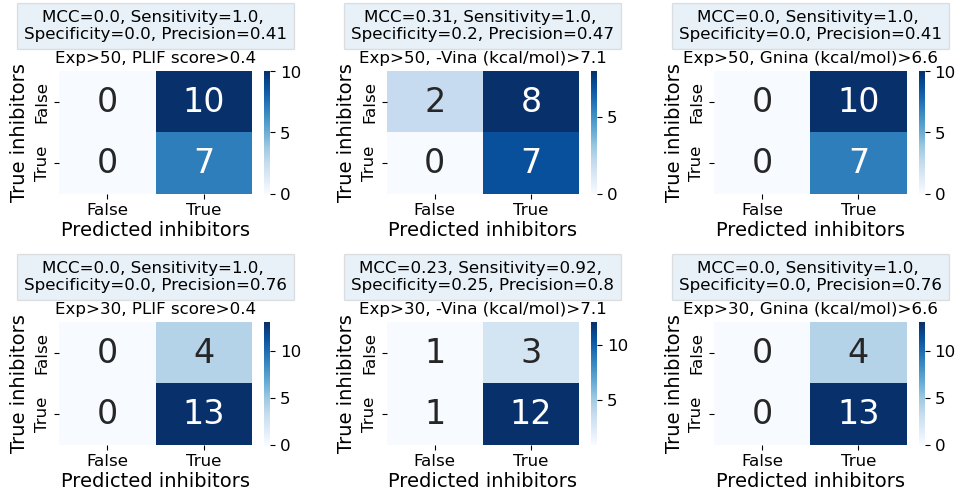

In [19]:
true_actives = sars_gen_C1[sars_gen_C1['Activity'] == 'active']
true_actives_ext = sars_gen_C1[sars_gen_C1['Activity'].isin(['active','partial'])]

fig, axs = plt.subplots(2, 3, figsize=(10, 5.2))
ax2 = get_conf_mat(axs[0, 0], sars_gen_C1['ByInteractionTypeAndResidueType'], sars_gen_C1['signal'], min(true_actives['ByInteractionTypeAndResidueType']), 50, 'PLIF score')
ax1 = get_conf_mat(axs[1, 0], sars_gen_C1['ByInteractionTypeAndResidueType'], sars_gen_C1['signal'], min(true_actives['ByInteractionTypeAndResidueType']), 30, 'PLIF score')

ax2 = get_conf_mat(axs[0, 1], -sars_gen_C1['Vina-score-premin'], sars_gen_C1['signal'], min(-true_actives['Vina-score-premin']), 50, '-Vina (kcal/mol)')
ax1 = get_conf_mat(axs[1, 1], -sars_gen_C1['Vina-score-premin'], sars_gen_C1['signal'], min(-true_actives['Vina-score-premin']), 30, '-Vina (kcal/mol)')

ax2 = get_conf_mat(axs[0, 2], sars_gen_C1['CNN_dock_affinity'], sars_gen_C1['signal'], min(true_actives['CNN_dock_affinity']), 50, 'Gnina (kcal/mol)')
ax1 = get_conf_mat(axs[1, 2], sars_gen_C1['CNN_dock_affinity'], sars_gen_C1['signal'], min(true_actives['CNN_dock_affinity']), 30, 'Gnina (kcal/mol)')
""
fig.subplots_adjust(hspace=1)
#fig.savefig("/Users/castelm3/Documents/Github/asapdiscovery_orig/local/SARS_genetics/conf_matrix_ensit_multi.pdf", bbox_inches='tight', pad_inches=0.5)
fig.tight_layout()

## ROC curves

AUC is 0.56, with bootstrap-sampling is 0.567+/-0.143
95% Confidence Interval: [0.30, 0.83]
AUC is 0.44, with bootstrap-sampling is 0.451+/-0.136
95% Confidence Interval: [0.18, 0.71]
AUC is 0.64, with bootstrap-sampling is 0.642+/-0.142
95% Confidence Interval: [0.34, 0.90]
AUC is 0.82, with bootstrap-sampling is 0.824+/-0.112
95% Confidence Interval: [0.56, 1.00]
AUC is 0.64, with bootstrap-sampling is 0.654+/-0.147
95% Confidence Interval: [0.34, 0.91]
AUC is 0.67, with bootstrap-sampling is 0.675+/-0.151
95% Confidence Interval: [0.33, 0.94]
AUC is 0.64, with bootstrap-sampling is 0.637+/-0.15
95% Confidence Interval: [0.30, 0.90]
AUC is 0.61, with bootstrap-sampling is 0.612+/-0.147
95% Confidence Interval: [0.32, 0.89]
AUC is 0.63, with bootstrap-sampling is 0.632+/-0.143
95% Confidence Interval: [0.33, 0.89]


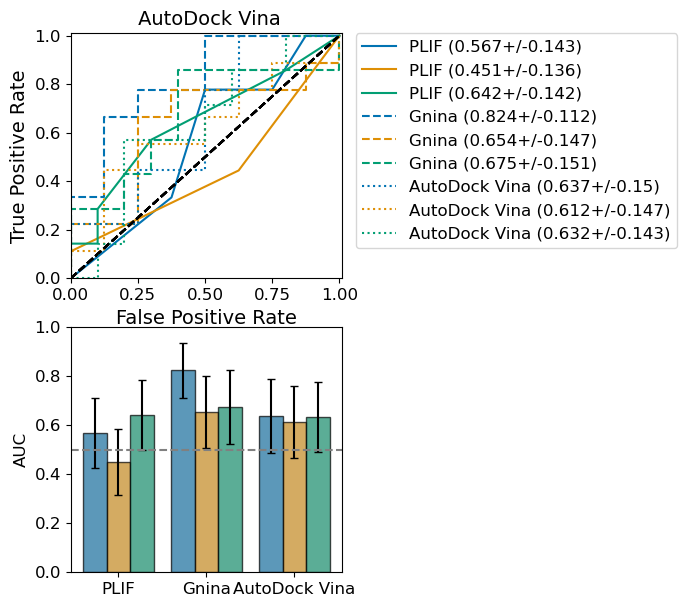

In [20]:
import seaborn as sns
fig, ax = plt.subplots(2, 1, figsize=(3.5, 7), sharex=False)

datasets = [sars_gen_A1, sars_gen_B1, sars_gen_C1]
ligands = [
    "ASAP-0020960",
    "ASAP-0017445",
    "ASAP-0016506",
]
styles = ['-', '--', ':']
labels = ['PLIF', 'Gnina', 'AutoDock Vina']
feature_cols = ['ByInteractionTypeAndResidueType', 'CNN_dock_affinity', 'Vina-score-premin']

df_list = []

colors = sns.color_palette("colorblind", n_colors=len(ligands))
color_map = dict(zip(labels, colors))

# Plot ROC curves

for label, col, style in zip(labels, feature_cols, styles):

    for dataset, color, ligand in zip(datasets, colors, ligands):
        y_true = dataset['signal'] > 50
        y_score = dataset[col] if 'Vina' not in col else -dataset[col]  # Negate Vina scores
        
        # ROC curve
        ax1 = get_roc_curve(ax[0], y_score, y_true, pred_type=label, title='', n_bootstraps=500, 
                            color=color, lstyle=style, box=False, legend=True)
        mean_auc, standard_error, ci_lower, ci_upper = bootstrap_auc(y_score, y_true, n_bootstraps=500)
        
        # Store AUC info with CI
        df_list.append({
            "ligand": ligand,
            "feature": label,
            "auc": mean_auc,
            "standard_error": standard_error,
        })

# Style for ROC panel
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Create AUC DataFrame and barplot
df_auc = pd.DataFrame(df_list)
hue_order = ligands
sns.barplot(
    data=df_auc,
    x="feature", y="auc", hue="ligand",
    order=labels, hue_order=hue_order,
    palette="colorblind", alpha=.7, ax=ax[1],
    errorbar=None, edgecolor="black"
)

# Manually add standard error bars
for ligand, container in zip(hue_order, ax[1].containers):
    for i, bar in enumerate(container):
        feature = labels[i]  # one bar per feature within a ligand
        x = bar.get_x() + bar.get_width() / 2
        height = bar.get_height()
        
        row = df_auc[(df_auc["ligand"] == ligand) & (df_auc["feature"] == feature)]
        if not row.empty:
            yerr = row["standard_error"].values[0]
            ax[1].errorbar(x, height, yerr=yerr, fmt='none', ecolor='black', capsize=3)

ax[1].set_ylabel("AUC")
ax[1].axhline(0.5, color='gray', linestyle='dashed')
ax[1].set_ylim(0, 1)
ax[1].legend([],[], frameon=False)
ax[1].set_xlabel("")

fig.tight_layout()
fig.subplots_adjust(wspace=0.15)
fig.savefig("/Users/castelm3/Documents/Github/asapdiscovery_orig/local/SARS_genetics/roc_scores_asap.pdf", bbox_inches='tight', pad_inches=0.5)